In [1]:
# retrieve github's code
!rm -rf BioFaceNet
!git clone https://github.com/bznick98/BioFaceNet.git

import sys
sys.path.insert(0, '/content/BioFaceNet')

Cloning into 'BioFaceNet'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 60 (delta 21), reused 49 (delta 10), pack-reused 0
Unpacking objects: 100% (60/60), done.


In [2]:
# retrive data from google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
data_dir = '/content/gdrive/MyDrive/NeuralFaceEditing-Dataset'
!ls {data_dir}

zx_7_d10_inmc_celebA_01.hdf5	zx_7_d10_inmc_train_smileN.hdf5
zx_7_d10_inmc_celebA_02.hdf5	zx_7_d10_inmc_train_smileP.hdf5
zx_7_d10_inmc_celebA_03.hdf5	zx_7_d3_lrgb_celebA_01.hdf5
zx_7_d10_inmc_celebA_04.hdf5	zx_7_d3_lrgb_celebA_02.hdf5
zx_7_d10_inmc_celebA_05.hdf5	zx_7_d3_lrgb_celebA_03.hdf5
zx_7_d10_inmc_celebA_20.hdf5	zx_7_d3_lrgb_celebA_04.hdf5
zx_7_d10_inmc_test_smileN.hdf5	zx_7_d3_lrgb_celebA_05.hdf5
zx_7_d10_inmc_test_smileP.hdf5	zx_7_d3_lrgb_celebA_20.hdf5


In [4]:
# custom model & modules
from datasets.celebA import CelebADataLoader
from BioFaceNet import BioFaceNet
from loss import loss

In [5]:
# required libraries
import numpy as np
import torch
import matplotlib.pyplot as plt
import os

from tqdm import tqdm
from torch.optim import SGD

In [6]:
# basically train.py below:
# argument parsing
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--epochs', type=int, default=20, help='number of epochs to train')
parser.add_argument('--show', action='store_true', help='if enabled, plot 5 sample images')
parser.add_argument('--lr', type=float, default=1e-5, help='learning rate')
parser.add_argument('--test_forward', action='store_true', help='if enabled, test forward pass by feeding 1 image')
parser.add_argument('--viz', action='store_false', help='if enabled, images of target/model output will be plotted every batch')
parser.add_argument('--save_dir', type=str, default="checkpoints/", help='directory for saving trained model')
parser.add_argument('--data_dir', type=str, default=data_dir, help='directory for training datasets')

# 'args=[]' ONLY FOR COLAB
args = parser.parse_args(args=[])

def train(args):
    # make directory for checkpoints saving
    os.makedirs(args.save_dir, exist_ok=True)

    # auto enable gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # data path lists
    inmc_list = [
        'zx_7_d10_inmc_celebA_20.hdf5',
        'zx_7_d10_inmc_celebA_05.hdf5',
        # 'zx_7_d10_inmc_celebA_04.hdf5',
        # 'zx_7_d10_inmc_celebA_03.hdf5',
        # 'zx_7_d10_inmc_celebA_02.hdf5',
        # 'zx_7_d10_inmc_celebA_01.hdf5'
    ]
    lrgb_list = [
        'zx_7_d3_lrgb_celebA_20.hdf5',
        'zx_7_d3_lrgb_celebA_05.hdf5',
        # 'zx_7_d3_lrgb_celebA_04.hdf5',
        # 'zx_7_d3_lrgb_celebA_03.hdf5',
        # 'zx_7_d3_lrgb_celebA_02.hdf5',
        # 'zx_7_d3_lrgb_celebA_01.hdf5'
    ]

    # inserting data dir in the front of filename
    inmc_list = [os.path.join(args.data_dir, fn) for fn in inmc_list]
    lrgb_list = [os.path.join(args.data_dir, fn) for fn in lrgb_list]

    # trainin dataloader
    train_loader = CelebADataLoader(inmc_list, lrgb_list).loader

    # network
    model = BioFaceNet(device=device)
    model.to(device) 

    # optimizer
    optim = SGD(
        model.parameters(),
        lr=args.lr
    )

    # training
    for epoch in range(args.epochs):
        with tqdm(train_loader, unit="batch") as tepoch:
            for batch in tepoch:
                # get batch items
                image, normal, mask, actual_shading, spherical_harmonics_param = [data.to(device) for data in batch]

                # forward pass
                fmel, fblood, pred_shading, pred_specular, b, lighting_params = model(image)

                # decode (physcial model based)
                appearance, pred_shading, pred_specular, b = model.decode(fmel, fblood, pred_shading, pred_specular, b, lighting_params)

                # pack predicted items for loss computation
                predicts = {
                    'appearance': appearance,
                    'b': b,
                    'specular': pred_specular,
                    'shading': pred_shading
                }

                targets = {
                    'appearance': image,
                    'shading': actual_shading,
                    'mask': mask
                }

                # compute loss
                batch_loss = loss(predicts, targets)

                # reset optimizer & backprop
                optim.zero_grad()
                batch_loss.backward()
                optim.step()

                # update info
                tepoch.set_postfix(epoch="{}/{}".format(epoch+1, args.epochs), loss=batch_loss.cpu().detach().numpy())

        # visualize training progress
        if args.viz:
            model.visualize_training_progress(image, actual_shading, mask, appearance, pred_shading, pred_specular, fmel, fblood)

        # save model each epoch
        ckpt_filename = "model_checkpoint_{}.pt".format(epoch)
        save_path = os.path.join(args.save_dir, ckpt_filename)
        state = {
            'epoch':epoch,
            'state_dict':model.state_dict(), # use model.load_state_dict(torch.load(XX)) when resume trainig
        }
        torch.save(state, save_path)



In [7]:
!ls /content/
%cd /content/BioFaceNet/
!pwd

BioFaceNet  gdrive  sample_data
/content/BioFaceNet
/content/BioFaceNet


12157 data samples are loaded.


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/190 [00:00<?, ?batch/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/n

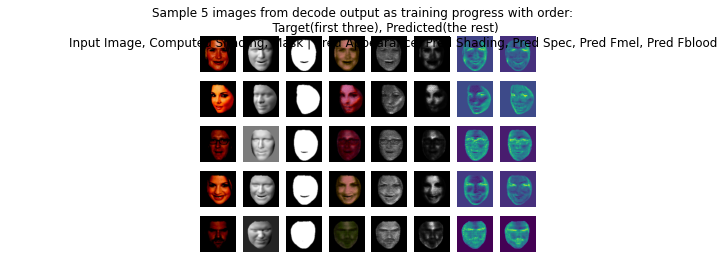

100%|██████████| 190/190 [01:01<00:00,  3.07batch/s, epoch=2/20, loss=37.65277]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range f

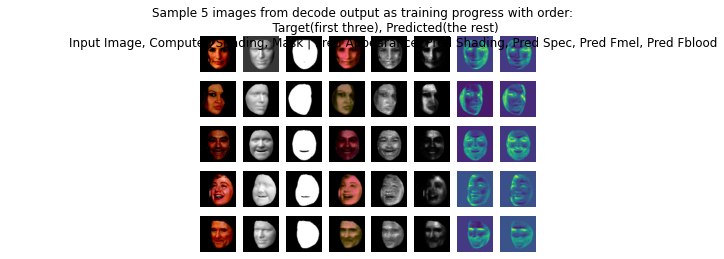

100%|██████████| 190/190 [01:02<00:00,  3.06batch/s, epoch=3/20, loss=38.816475]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range 

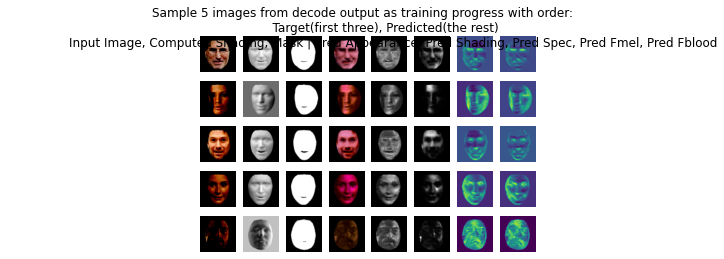

100%|██████████| 190/190 [01:02<00:00,  3.05batch/s, epoch=4/20, loss=28.476349]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range 

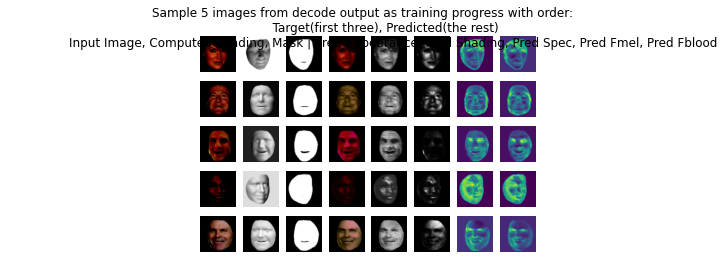

100%|██████████| 190/190 [01:02<00:00,  3.06batch/s, epoch=5/20, loss=31.249699]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range 

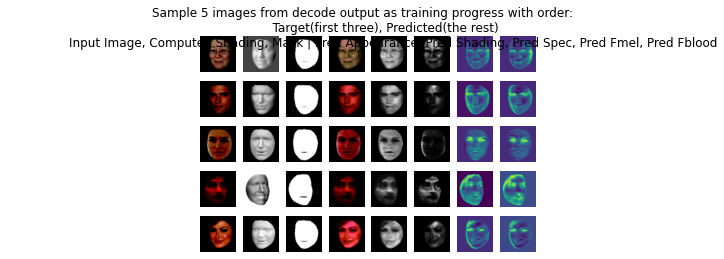

100%|██████████| 190/190 [01:02<00:00,  3.05batch/s, epoch=6/20, loss=40.801643]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range 

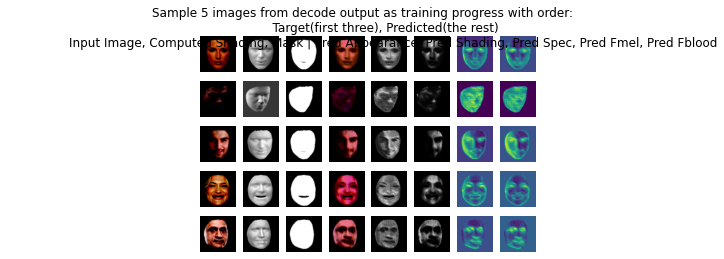

100%|██████████| 190/190 [01:03<00:00,  2.99batch/s, epoch=7/20, loss=28.752777]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range 

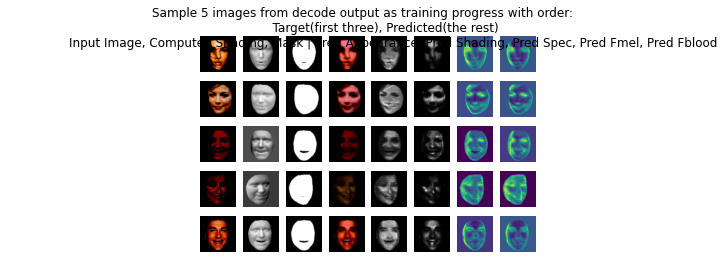

100%|██████████| 190/190 [01:02<00:00,  3.04batch/s, epoch=8/20, loss=31.670858]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range 

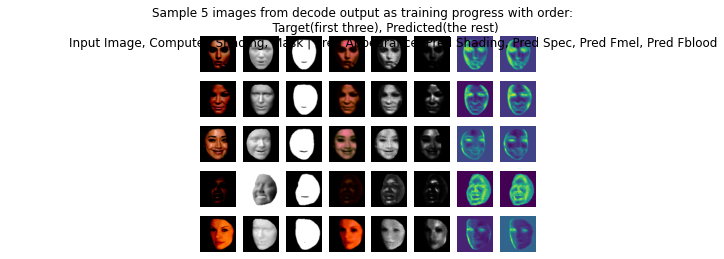

100%|██████████| 190/190 [01:02<00:00,  3.06batch/s, epoch=9/20, loss=28.41183]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range f

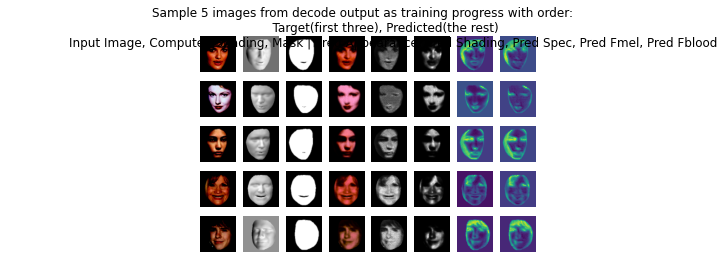

100%|██████████| 190/190 [01:02<00:00,  3.05batch/s, epoch=10/20, loss=30.894583]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range

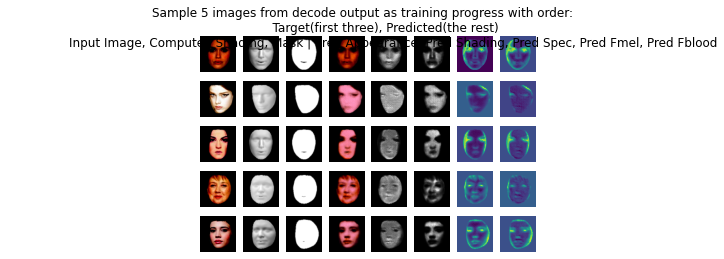

100%|██████████| 190/190 [01:02<00:00,  3.06batch/s, epoch=11/20, loss=26.208025]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range

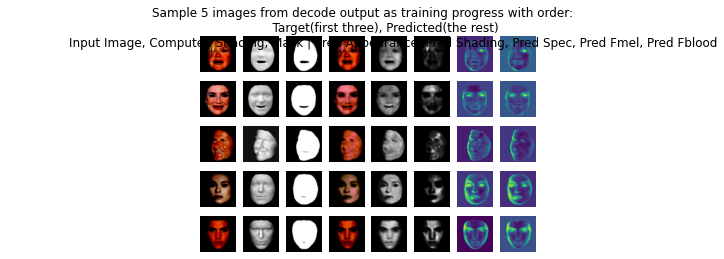

100%|██████████| 190/190 [01:02<00:00,  3.05batch/s, epoch=12/20, loss=29.74288]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range 

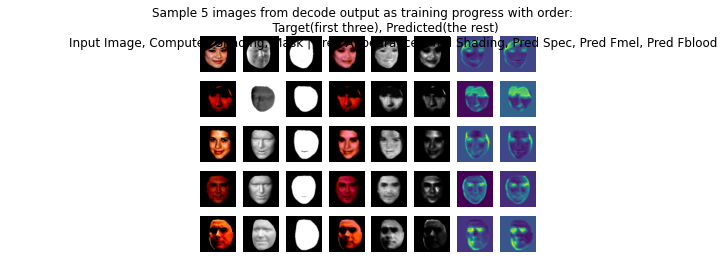

100%|██████████| 190/190 [01:02<00:00,  3.06batch/s, epoch=13/20, loss=26.769264]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range

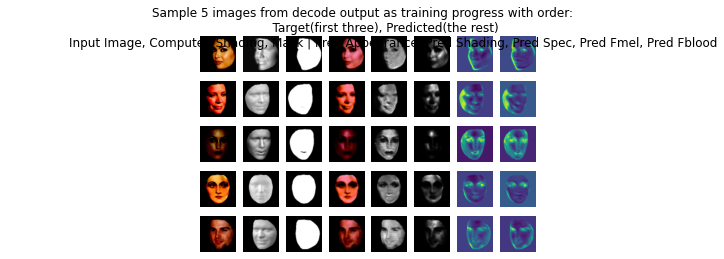

100%|██████████| 190/190 [01:02<00:00,  3.05batch/s, epoch=14/20, loss=33.40976]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range 

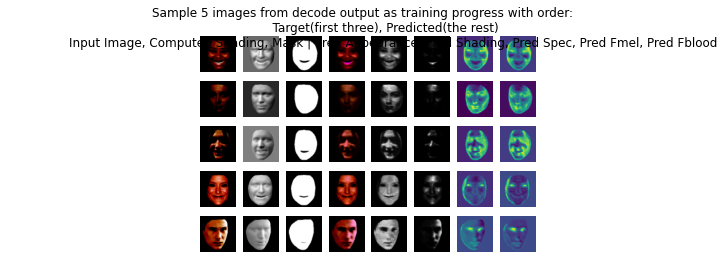

100%|██████████| 190/190 [01:02<00:00,  3.03batch/s, epoch=15/20, loss=28.92765]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range 

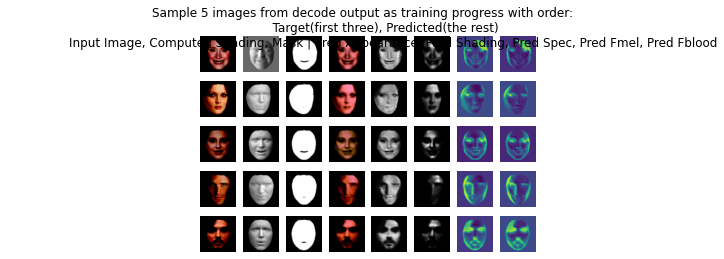

100%|██████████| 190/190 [01:02<00:00,  3.03batch/s, epoch=16/20, loss=24.965002]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range

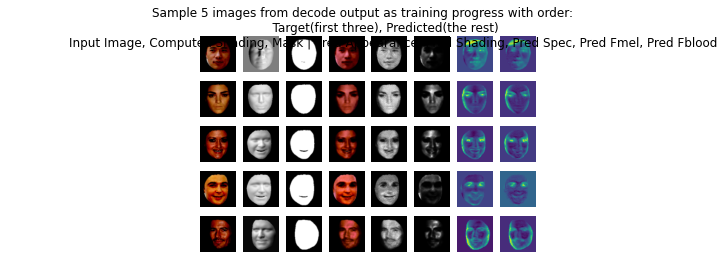

100%|██████████| 190/190 [01:02<00:00,  3.05batch/s, epoch=17/20, loss=29.309103]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range

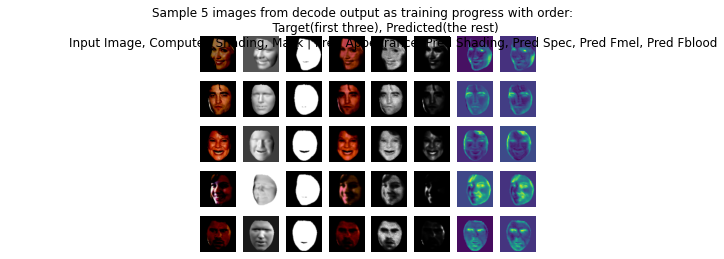

100%|██████████| 190/190 [01:03<00:00,  3.00batch/s, epoch=18/20, loss=29.89897]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range 

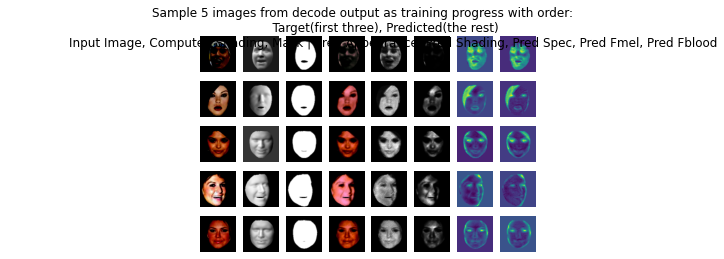

100%|██████████| 190/190 [01:02<00:00,  3.04batch/s, epoch=19/20, loss=33.754055]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range

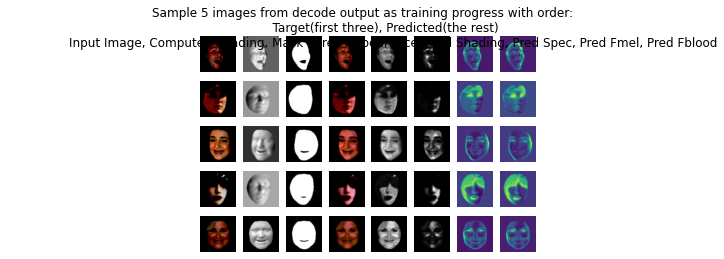

100%|██████████| 190/190 [01:02<00:00,  3.03batch/s, epoch=20/20, loss=30.566471]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range

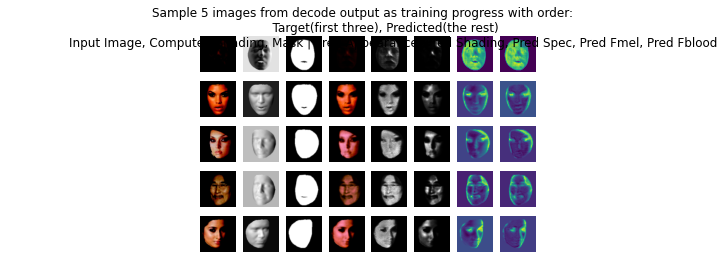

In [8]:
train(args)

In [9]:
# check saved model
!ls checkpoints

model_checkpoint_0.pt	model_checkpoint_16.pt	model_checkpoint_4.pt
model_checkpoint_10.pt	model_checkpoint_17.pt	model_checkpoint_5.pt
model_checkpoint_11.pt	model_checkpoint_18.pt	model_checkpoint_6.pt
model_checkpoint_12.pt	model_checkpoint_19.pt	model_checkpoint_7.pt
model_checkpoint_13.pt	model_checkpoint_1.pt	model_checkpoint_8.pt
model_checkpoint_14.pt	model_checkpoint_2.pt	model_checkpoint_9.pt
model_checkpoint_15.pt	model_checkpoint_3.pt
